# 1_data_preparation.ipynb

Converts 'open-high-low-close' (OHLC) price data into a format suitable for machine learning.  Target labels are generated according to (potential) profitable trading conditions being met.  Extra data features are created, price and volume data are centralised around their moving averages, whilst time and day labels are separated out and one-hot encoded.  

The working dataframe is then transformed into a tensor of dimensions [batch_size, steps, channels] by using a rolling window method.  Appropriate category labels are selected to match the last step in each window, and transformed into a tensors of dimensions [batch_size, categories].

In [155]:
from imports.noise_generator import NoiseGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import pickle

pd.set_option('display.max_columns', 50)

## Data Exploration

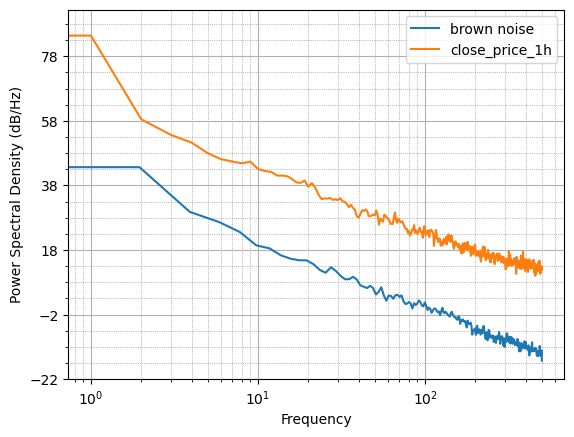

In [156]:
# assess power spectral density of close prices
df = pd.read_csv('data/OHLC_1h.csv', header=0, sep=',')

# compare with power spectral density of Brownian noise
ng = NoiseGenerator()
brown_noise = ng.generate(dt=1e-5, n=10000, colour=ng.brown()) * 1000
plt.psd(brown_noise, 512, 1 / 0.001, label='brown noise')

# draw graph
plt.psd(df['close'].to_numpy(), 1000, 1 / 0.001, label='close_price_1h')
plt.xscale('log',base=10)
plt.minorticks_on()
plt.grid(which='minor', color='grey', linestyle=':', linewidth=0.5)
plt.legend()

plt.show()

The Power Spectral Density graph is as expected, and tells us that:
1. There are no dominant (long-term) cyclical pattens in the data.
2. There is some structure to the data... A 6dB/octave roll off. (NB: This 'structure' is also shared by brown noise and random walks).
4. First-order filters (which are characterised by a similar roll off) are therefore unable to fully detrend the data, so should be used/interpreted with care.

## Feature Engineering
1. Create categorical labels.

In [ ]:

def convert_unix_time_into_day(seconds):
    """ returns day of week as category label """
    day_of_week = time.strftime('%A', time.localtime(seconds))
    dict = {'Saturday':1, 'Sunday':2, 'Monday':3, 'Tuesday':4, 'Wednesday':5, 'Thursday':6, 'Friday':7}
    day_code = dict[day_of_week]
    return day_code


def wwma(pd_series, period):
    """ w. wilder's EMA """
    return pd_series.ewm(alpha=1/period, adjust=False, ignore_na=True).mean()


def atr(df, length=14):
    """ average true range (for column with latest values at top) """
    df_high, df_low, df_prev_close = df['high'], df['low'], df['close'].shift()
    df_tr = [df_high- df_low, df_high - df_prev_close, df_low - df_prev_close]
    df_tr = [tr.abs() for tr in df_tr]
    df_tr = pd.concat(df_tr, axis=1).max(axis=1)
    df_atr = wwma(df_tr, length)
    return df_atr


ATR_MULT = 0.25 

# load price data into dataframe and reorder to recent = last
df = pd.read_csv('data/OHLC_1h.csv', header=0, sep=',')
df = df.sort_index(ascending=False, ignore_index=True)

# calculate 'average true range' and add as column to dataframe
df_atr = atr(df)
df['ATR'] = df_atr

# create target labels 
y_labels =[]

for i in range(2,len(df)):

    # up condition: (high or high[1] > high[2] + spread) and (low and low[1] > low[2] + spread) 
    if (
        ( df.loc[i, 'high'] > (df.loc[i-2, 'high'] + ATR_MULT * df.loc[i, 'ATR'])  or  
        df.loc[i-1, 'high'] > (df.loc[i-2, 'high'] + ATR_MULT * df.loc[i, 'ATR']) )  and 
        ( df.loc[i, 'low'] > (df.loc[i-2, 'low'] + ATR_MULT * df.loc[i, 'ATR'])  and  
        df.loc[i-1, 'low'] > (df.loc[i-2, 'low'] + ATR_MULT * df.loc[i, 'ATR']) )
    ):
        label = 'up'

    # down condition: (low or low[1] < low[2] - spread) and (high and high[1] < high[2] - spread)
    elif (
        ( df.loc[i, 'low'] < (df.loc[i-2, 'low'] - ATR_MULT * df.loc[i, 'ATR'])  or  
          df.loc[i-1, 'low'] < (df.loc[i-2, 'low'] - ATR_MULT * df.loc[i, 'ATR']) )  and 
        ( df.loc[i, 'high'] < (df.loc[i-2, 'high'] - ATR_MULT * df.loc[i, 'ATR'])  and  
          df.loc[i-1, 'high'] < (df.loc[i-2, 'high'] - ATR_MULT * df.loc[i, 'ATR']) )
        ):
        label = 'down'
    
    else:
        label = 'flat'

    y_labels.append(label)

y_labels.extend([float('NaN'), float('NaN')])

# add labels to new dataframe column
df['target'] = y_labels

# create day and hour categories
df['day'] = df['unix'].map(lambda _: convert_unix_time_into_day(_))
df['hour'] = df['date'].str.slice(start=11, stop=13).apply(pd.to_numeric) + 1
df['year'] = df['date'].str.slice(start=0, stop=4).apply(pd.to_numeric)
print(df.head())

2. Derive features using first-order filters and significant levels

In [ ]:

def bollinger_k(df, length=20):
    """ bollinger coeffient and delta_sdev"""
    df_tp = (df['high'] + df['low'] + df['close']) / 3
    df_sma = df_tp.rolling(length).mean()
    df_sdev = df_tp.rolling(length).std()
    df_delta_sdev = df_sdev.diff()
    df_bk = (df['close'] - df_sma) / df_sdev 
    return df_bk, df_delta_sdev


PERIOD = 50
PERIOD_FAST = 20
HI_LO_WINDOW = 40

# calculate simple moving averages of closing price
df[f'SMA_{PERIOD}'] = df['close'].rolling(PERIOD).mean()
df[f'SMA_{PERIOD_FAST}'] = df['close'].rolling(PERIOD_FAST).mean()

# calculate simple moving averages of volume
df[f'vol SMA_{PERIOD}'] = df['volume USD'].rolling(PERIOD).mean()
df[f'vol SMA_{PERIOD_FAST}'] = df['volume USD'].rolling(PERIOD_FAST).mean()

# centralise price and volume data around relevant slower SMA
df['open_'] = (df['open'] - df[f'SMA_{PERIOD}']) / df[f'SMA_{PERIOD}']
df['high_'] = (df['high'] - df[f'SMA_{PERIOD}']) / df[f'SMA_{PERIOD}']
df['low_'] = (df['low'] - df[f'SMA_{PERIOD}']) / df[f'SMA_{PERIOD}']
df['close_'] = (df['close'] - df[f'SMA_{PERIOD}']) / df[f'SMA_{PERIOD}']
df['vol_'] = (df['volume USD'] - df[f'vol SMA_{PERIOD}']) / df[f'vol SMA_{PERIOD}']

# centralise price and volume data around relevant faster SMA
df['close_f'] = (df['close'] - df[f'SMA_{PERIOD_FAST}']) / df[f'SMA_{PERIOD_FAST}']
df['vol_f'] = (df['volume USD'] - df[f'vol SMA_{PERIOD_FAST}']) / df[f'vol SMA_{PERIOD_FAST}']

# calculate highest high and lowest low in the last 'HI_LO_WINDOW' prices
df[f'HH_{HI_LO_WINDOW}'] = df['high'].rolling(HI_LO_WINDOW).max().shift()
df[f'LL_{HI_LO_WINDOW}'] = df['low'].rolling(HI_LO_WINDOW).min().shift()

# centralise close price around highest high and lowest low 
df['chh_'] = (df['close'] - df[f'HH_{HI_LO_WINDOW}']) / df[f'HH_{HI_LO_WINDOW}']
df['cll_'] = (df[f'LL_{HI_LO_WINDOW}'] - df['close']) / df[f'HH_{HI_LO_WINDOW}']

# calculate bollinger coeffient and standard deviation add as column to dataframe
df['bk'], df['d_sdev'] = bollinger_k(df, length=PERIOD_FAST)
print(df.head())

3. Separate catagorical dataframes and convert to one-hot encoding.

In [ ]:
# drop rows containing NaNs   
df = df.dropna(axis=0)

# create separate dataframe for one-hot encoded day/hour categories
df_time = df[['day', 'hour', 'year']].copy()
df_time = pd.get_dummies(df_time, columns=['day', 'hour', 'year'])

# create separate dataframe for one-hot encoded target categories
df_ylabels = df['target'].copy()
df_ylabels = pd.get_dummies(df_ylabels, columns=['target'])

# tidy up price data
df = df.drop(columns=['unix', 'date', 'volume USD', 'volume', 
                      'open', 'high', 'low', 'close', 
                      f'SMA_{PERIOD}', f'SMA_{PERIOD_FAST}', 
                      f'vol SMA_{PERIOD}', f'vol SMA_{PERIOD_FAST}', 
                      'day', 'hour', 'year', 'target', 'ATR', 'open_',
                      f'HH_{HI_LO_WINDOW}', f'LL_{HI_LO_WINDOW}'], axis=1)

# check dataframes
print(df.head(), '\n', len(df))
print(df_time.head(), '\n', len(df_time))
print(df_ylabels.head(), '\n', len(df_ylabels))

4. Scale standard deviations of selected columns then check overall balance of data

In [ ]:
# scale column stdev with stdev(close_)
df['vol_'] = df['vol_'] * (df['close_'].std() / df['vol_'].std())
df['close_f'] = df['close_f'] * (df['close_'].std() / df['close_f'].std())
df['vol_f'] = df['vol_f'] * (df['close_'].std() / df['vol_f'].std())
df['chh_'] = df['chh_'] * (df['close_'].std() / df['chh_'].std())
df['cll_'] = df['cll_'] * (df['close_'].std() / df['cll_'].std())
df['bk'] = df['bk'] * (df['close_'].std() / df['bk'].std())
df['d_sdev'] = df['d_sdev'] * (df['close_'].std() / df['d_sdev'].std())

# check data
print('COUNT:\n', df_ylabels.sum(axis=0))
print('MEANS:\n', df.mean())
print('STDEVS:\n', df.std())

## Prepare Tensors
Slices dataframe into many discrete classification problems.

In [161]:
WINDOW = 20
STEP = 2

# create numpy arrays to receive data
price_series = np.zeros(shape=(WINDOW, len(df.columns)))
time_categories = np.zeros(shape=(1, len(df_time.columns)))
target_categories = np.zeros(shape=(1, 3))

# iterate through price dataframe concatenating discrete arrays of size 'WINDOW', and spacing 'STEP'
batch_size = (len(df)-WINDOW) // STEP
for i in range(batch_size): 
    arr = df.iloc[[(i*STEP)+j for j in range(WINDOW)], [k for k in range(len(df.columns))]].to_numpy()
    price_series = np.concatenate((price_series, arr))

# iterate through categorical dataframes concatenating data relating to bottom row of each price window
for i in range(batch_size): 
    arr = df_time.iloc[[(i*STEP) + WINDOW], : ].to_numpy()
    time_categories = np.concatenate((time_categories, arr))
    
    arr = df_ylabels.iloc[[(i*STEP) + WINDOW], : ].to_numpy()
    target_categories = np.concatenate((target_categories, arr))

# reshape arrays
price_series = np.reshape(price_series, (batch_size+1, WINDOW, len(df.columns)))
time_categories = np.reshape(time_categories, (batch_size+1, len(df_time.columns)))
target_categories = np.reshape(target_categories, (batch_size+1, 3))

# delete intial 'zeros' array elements
price_series = np.delete(price_series, 0, axis=0)
time_categories = np.delete(time_categories, 0, axis=0)
target_categories = np.delete(target_categories, 0, axis=0)

# check arrays
print('price_series', price_series.shape)
print('time_categories', time_categories.shape)
print('target_categories', target_categories.shape)

# binarize target categories, index(1) == positive class
up_targets = target_categories[:, [1, 0]]
dn_targets = target_categories[:, [1, 2]]

# check arrays
print('up_targets', up_targets.shape)
print('dn_targets', dn_targets.shape)

# save data
with open('data/all_data.pkl', 'wb') as file:
    pickle.dump((price_series, time_categories, up_targets, dn_targets), file, protocol=4)

price_series (25222, 20, 10)
time_categories (25222, 38)
target_categories (25222, 3)
up_targets (25222, 2)
dn_targets (25222, 2)


## Notes

In [162]:
## check negative numbers don't affect the convolution
## add commission level to 'flat' calculation
